# Lecture 7. Solvers for large-scale sparse systems

## Previous lecture
- PDEs discretization
- Sparse matrices
- Demos

## Todays lecture
- Direct solvers
- Iterative solvers

## Typical problems we need to solve

1. Solving linear systems $Ax = f$
2. Solving eigenvalue problem $A x_i = \lambda x_i$
3. Computing matrix functions, i.e. $y = e^{At} y_0$

To solve 2 and 3 we need to solve auxiliary linear systems. 

Types of solvers
- iterative: matrix-by-vector product is **easy**, but the matrix is typically **ill-conditioned**, thus iterative methods will converge slowly, and **preconditioners** are needed
- direct: no problem with ill-conditioning, but complexity is not optimal

## Fast direct solvers

One of the research directions for solving sparse linear systems

$$
A x = f
$$

with a given **sparse matrix** $A$ are so-called **direct solvers** which try to factorize the matrix $A$.

The simplest decomposition is the **sparse LU** factorization of the form

$$A = LU,$$

where $L$ is **sparse lower triangular**, and $U$ is **sparse upper triangular**.

## Sparse Gaussian elimination and graphs

- The crucial concept to analyze the efficiency of sparse matrix factorization is the **sparse matrix graph**.

- The graph of the sparse matrix has vertices $i$, and the edge exists if $A_{ij} \ne 0$.

- The pattern of the $L$ factor can be inferred from the **symbolic** operations in the sparse matrix graph.

## Graph of the sparse matrix

For simplicity, consider **Cholesky factorization** for a **symmetric positive-definite matrix** $A$:

$$A = LL^{\top}.$$

The positions of non-zero elements can be inferred from the code

```

for j from 1 to N:

   Add edges between j's higher-order neighbors
   
```

<img src='pic/screen.png'>

## Permutation selection

- The fill-in of a matrix are those entries which change from an initial zero to a nonzero value during the execution of an algorithm.

- The fill-in is different for different permutations. So, before factorization we need to find reordering which produces the smallest fill-in.

- For one order you get sparse factorization, for another - dense factors.

In fact, for a Cholesky factorization you compute

$$A = P L L^{\top} P^{\top},$$

where $P$ is a **permutation matrix**.

## 2D model problem

- 2D model problem: Poisson equation on $n \times n$ finite difference grid
- Total number of unknowns $n^2 = N$
- Theoretical results from the fill-in:
  - Natural (no) permutation: $\mathcal{O}(N^{3/2})$
  - Random permutation: expected value is $\mathcal{O}(N \log N)$
  - Nested dissection permutation: $\mathcal{O}(N)$.
  
  By **fill-in** I mean the number of non-zeros in the $L$ factor.

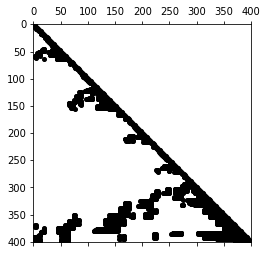

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix, csr_matrix, coo_matrix
import matplotlib.pyplot as plt
%matplotlib inline

n = 20
ex = np.ones(n);
lp1 = sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
e = sp.sparse.eye(n)
A = sp.sparse.kron(lp1, e) + sp.sparse.kron(e, lp1)
A = csc_matrix(A)
T = scipy.sparse.linalg.splu(A)
plt.spy(T.L, marker='.', color='k', markersize=8)

## Nested dissection ordering

 A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components
- A nested dissection ordering for an $N$-vertex graph $G$ numbers its
vertices from $1$ to $N$ as follows:
    - Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
    - Number the vertices of $S$ from $N − |S| + 1$ to $N$
    - Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, number it arbitrarily

It all boils down to finding good separators! 

## Nested dissection is "approximately optimal"

- From theory, nested dissection gives you optimal complexity

- Again, there are other methods that win for medium-sized problems

- They are based on **heuristic** matrix reordering techniques

## Banded reordering

- Make the matrix more "banded" (Reverse Cuthill-McKee, Sloan, etc.)

- The idea is to try to keep entries closer to the diagonal 

- It works well for matrices coming from "quasi-one dimensional" PDEs


## Minimal degree orderings

-  The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and repeat

- Efficient implementation is an issue (adding/removing elements)

- Current champion is "approximate minimal degree" by [Amestoy, Davis, Duff](https://pdfs.semanticscholar.org/606a/5dce82d9953aa18b732691b427231b87be90.pdf)

- It is **suboptimal** even for 2D problems

- In practice, it often wins for medium-sized problems.

## Nested dissection

- Find a separator, number it last, proceed recursively
- Optimal in theory
- In practice, beats others for very large problems

## Solving sparse matrices, coming from PDEs

<img src='pic/complexity2.png'>

## Separators in practice

Computing separators is not a **trivial task**.

Graph partitioning heuristics have been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph)
- Geometric partitioning (for meshes with specified vertex coordinates)
- Iterative-swapping (Kernighan-Lin, Fiduccia-Matheysses)
- Breadth-first search 

Many popular modern codes (e.g. Metis, Chaco) use multilevel iterative swapping.

## Iterative swapping

The "cost" of the separator is defined in a very natural way as the sum over edges:

$$T(A, B) = \sum_{e = (v_a, v_b), v_a \in  A, v_b \in B} \text{weight}(e).$$

Given some initial partion, test some subsets $X$ and $Y$ of the same size, and if swapping decreases the cost function - swap them.

## Spectral bisection

The idea of spectral bisection goes back to Fiedler.

We introduce the **graph Laplacian** of the matrix, which is defined as as symmetric matrix

that

$$L_{ii} = \text{degree of node } i$$

$$L_{ij} = \begin{cases} -1, & i \ne j\\ 0 & \text{otherwise}\end{cases}$$

- Rows of $L$ sum to zero, thus there is an eigenvalue $1$
- Eigenvalues are non-negative.
- The number of connected components of a graph is the number of **zero eigenvalues**


## When to use sparse direct solvers?

- They work well for 1D/2D problems and "not so large" 3D problems. 

- The problem with memory becomes very harsh for 3D problems, thus other methods are needed.

## Structure of sparse matrices, coming from PDEs

For a general sparse matrix, fast direct method is typically the method of choice.

A sparse matrix coming from a PDE, the rows/columns can be associated with **points** (elements) in a $d$-dimensional space, just like for the $\mathcal{H}$-matrix case.

This is an additional structure that can be used in many ways, for example by approximating factors using $\mathcal{H}$-matrix case.

## Fast direct solvers and $\mathcal{H}$-matrices

- Inverse of a sparse matrix is typically not sparse
- But for PDEs it has lowrank blocks ($\mathcal{H}, \mathcal{H}^2$-matrix). 
- This information can be utilized to build efficient solver. 

Details on the blackboard.

In [3]:
import numpy as np
import scipy.sparse as spsp
n = 7
ex = np.ones(n);
a = spsp.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
a = a.todense()
b = np.array(np.linalg.inv(a))
print(a)
print(b)

[[-2.  1.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  1. -2.]]
[[-0.875 -0.75  -0.625 -0.5   -0.375 -0.25  -0.125]
 [-0.75  -1.5   -1.25  -1.    -0.75  -0.5   -0.25 ]
 [-0.625 -1.25  -1.875 -1.5   -1.125 -0.75  -0.375]
 [-0.5   -1.    -1.5   -2.    -1.5   -1.    -0.5  ]
 [-0.375 -0.75  -1.125 -1.5   -1.875 -1.25  -0.625]
 [-0.25  -0.5   -0.75  -1.    -1.25  -1.5   -0.75 ]
 [-0.125 -0.25  -0.375 -0.5   -0.625 -0.75  -0.875]]


## Iterative methods

- If we want to achieve $\mathcal{O}(N)$ complexity, then direct solvers are not appropriate
- If we want to solve partial eigenproblem, the full eigendecomposition is too costly

- For both problems we will use iterative, Krylov subspace solvers
- They treat the matrix as a **black-box** linear operator

## Matrix as a black box

We have now an absolutely different view on a matrix: 
- matrix is now a **linear operator**, that acts on a vector  
- this action can be computed in $\mathcal{O}(N)$ operations

**This is the only information** we know about the matrix: 

the <font color='red'> matrix-by-vector product (matvec) </font>

**Q:** can we solve linear systems using only matvecs?

**A:** of course, we can multiply by the colums of the identity matrix, and 

recover the full matrix, but it is not what we need.

## Krylov subspace methods

-  Krylov subspace of the matrix $A$ given vector $f$ is defined as 
$$
   K_m(A, f) = \mathrm{Span}(f, Af, A^2 f, \ldots, A^{m-1}f )
$$
- Krylov methods (known from NLA course):
    - CG works for SPD matrices, minimizes energy functional over Krylov subspace
    - Minres works for symmetric matrices, minimizes residual
    - GMRES works for general matrices, also minimizes residual but does not have recurrent formulas $\to$ restarting  
    - BiCGstab works for general matrices, does not minimize functional but has short recurrent formulas
    

## "Nonlinear GMRES" or Anderson acceleration

Use the GMRES-like idea to speed up a given fixed-point iteration

$$x_{k+1} = \Phi(x_k).$$

Idea: **use history** for the update, 

$$x_{k+1} = \Phi(x_k) + \sum_{s=1}^m \alpha_s (x_{k - s} - \Phi(x_{k - s})), $$

and the parameters $\alpha_s$ are selected to minimize the norm of the residual.

- This was actually older than the GMRES
- It is known as an Direct Inversion in Iterated Subspaces in Quantum Chemistry, or **Anderson Acceleration**.



## Battling the condition number

- The condition number problem is **un-avoidable** if only matvec is used
- Thus we need an **army of preconditioners** to solve it
- There are several **general purpose** preconditioners that we can use
- But often for a particular problem a special design is needed

## Preconditioner: general concept

The general concept of the preconditioner is simple:

Given a linear system 

$$A x = f,$$

we want to find the matrix $P_R$ (or $P_L$) such that 

1. Condition number of $AP_R^{-1}$ (right preconditioner) or $P^{-1}_LA$ (left preconditioner) or $P^{-1}_L A P_R^{-1}$ is better than for $A$
2. We can easily solve $P_Ly = g$ or $P_Ry = g$ for any $g$ (otherwise we could choose e.g. $P_L = A$)

Then we solve for (right preconditioner)

$$ AP_R^{-1} y = f \quad \Rightarrow \quad P_R x = y$$ 

or  (left preconditioner)

$$ P_L^{-1} A x = P_L^{-1}f,$$

or even both

$$ P_L^{-1} A P_R^{-1} y = P_L^{-1}f \quad \Rightarrow \quad P_R x = y.$$ 

- The best choice is of course $P = A,$ but this does not make life easier
- One of the ideas is to use other iterative methods (beside Krylov) as preconditioners.

## Incomplete LU


Suppose you want to eliminate a variable $x_1$, and the equations have the form

$$5 x_1 + x_4 + x_{10} = 1, \quad 3 x_1 + x_4 + x_8 = 0, \ldots,$$

and in all other equations $x_1$ are not present. 

After the elimination, only $x_{10}$ will enter additionally to the second equation (new fill-in).

$$x_4 + x_8 + 3(1 - x_4 - x_{10})/5 = 0$$

In the Incomplete $LU$ case (actually, ILU(0)) we just throw away the **new fill-in**.

## Incomplete-LU: formal definition

We run the usual LU-decomposition cycle, but avoid inserting non-zeros **other** than the initial non-zero pattern. 

```python

    L = np.zeros((n, n))
    
    U = np.zeros((n, n))
    
    for k in range(n): #Eliminate one row
        
        L[k, k] = 1
        
        for i in range(k+1, n):
            
            L[i, k] = a[i, k] / a[k, k]
            
            for j in range(k+1, n):
                
                a[i, j] = a[i, j] - L[i, k] * a[k, j]  #New fill-ins appear here
                
        for j in range(k, n):
            
            U[k, j] = a[k, j]
            
```

## ILU(k)

- Yousef Saad (who is the author of GMRES) also had a seminal paper on the **Incomplete LU** decomposition

- A good book on the topic is [Iterative methods for sparse linear systems](https://www-users.cs.umn.edu/~saad/IterMethBook_2ndEd.pdf) by Saad, Yousef (1996)

- And he proposed **ILU(k)** method, which has a nice interpretation in terms of graphs

## ILU(k): idea

- The idea of ILU(k) is very instructive and is based on the connection between sparse matrices and graphs

- Suppose you have an $n \times n$ matrix $A$ and a corresponding adjacency graph

- Then we eliminate one variable (vertex) and get a smaller system of size $(n-1) \times (n-1)$

- New edges (=fill-in) appears between high-order neighbors.

## LU & graphs

- The **ILU(k)** idea is to leave only the elements in $L$ and $U$ that are $k$-order neighbours in the original graph.

- The ILU(2) is very efficient, but for some reason completely abandoned (i.e. there is no implementation in MATLAB and SciPy).

There is an original [Sparsekit software](https://people.sc.fsu.edu/~jburkardt/f_src/sparsekit/sparsekit.html) by Saad, which works quite well.

## ILU Thresholded (ILUT)
A much more popular approach uses the so-called **thresholded LU**.

You do the standard Gaussian elimination with fill-ins, but either:

- Throw away elements that are smaller than threshold, and/or control the amount of non-zeros you are allowed to store.

- The smaller is the threshold, the better is the preconditioner, but more memory it takes.

It is denoted ILUT($\tau$).

## Symmetric positive definite case

In the SPD case, instead of incomplete LU you should use Incomplete Cholesky, which is twice faster and consumes twice less memory.

- **ILUT** is implemented in [SciPy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.spilu.html#scipy.sparse.linalg.spilu)
- **Ichol** is implemented in [Scikit-sparse package](https://pythonhosted.org/scikits.sparse/cholmod.html) 
- You can try (nothing quite fancy, but it works)

## Second-order LU preconditioners

- There is a more efficient **second-order** LU factorization [proposed by I. Kaporin](http://www.researchgate.net/profile/I_Kaporin/publication/242940993_High_quality_preconditioning_of_a_general_symmetric_positive_definite_matrix_based_on_its_UTU__UTR__RTU-decomposition/links/53f72ad90cf2888a74976f54.pdf)

- It is but much less popular due to the limit of open-source implementations

- The idea is to approximate the matrix in the form

$$A \approx U_2 U^{\top}_2 + U^{\top}_2 R_2 + R^{\top}_2 U_2,$$

where $U_1$ and $U_2$ are low-triangular and sparse, whereare $R_2$ is small with respect to the drop tolerance parameter

- This is just the expansion of the $UU^{\top}$ with respect to the perturbation of $U$




## Summary
- Fast direct solvers are often the method of choice for small-sized problems.
- Iterative methods
- Preconditioning